In [173]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime, math
from news_test import daily_sentiment

In [123]:
filename = 'AAPL.csv' #pick stock
ticker = filename.split('.')[0] #get ticker
df = pd.read_csv('./data_clean/' + filename, index_col=0, sep=',') #load in dataset – uploaded on git, originally downloaded from https://www.kaggle.com/jacksoncrow/stock-market-dataset

In [170]:
#turn index col (string) into date col

def date_parse(s): #date strings are in form '2015-01-01'
    d = s.split('-')
    return datetime.date(int(d[0]), int(d[1]), int(d[2]))

df.index = df.index.map(date_parse)

df = df.query('index < datetime.date(2020,1,1)') #remove 2020 data, since we lack sentiment data for most of it

In [174]:
#make running sentiment column based on index (date) col
df['sentiment'] = [daily_sentiment(ticker, d) for d in df.index.values]

In [175]:
df

,open,high,low,close,adj close,volume,min,max,sentiment
date,,,,,,,,,
2015-01-02,111.389999,111.440002,107.349998,109.330002,100.216454,high,NaN,NaN,0.104297
2015-01-05,108.290001,108.650002,105.410004,106.250000,97.393181,high,106.250000,NaN,0.075262
2015-01-06,106.540001,107.430000,104.629997,106.260002,97.402374,high,NaN,NaN,0.056943
2015-01-07,107.199997,108.199997,106.699997,107.750000,98.768150,high,NaN,NaN,0.057881
2015-01-08,109.230003,112.150002,108.699997,111.889999,102.563072,high,NaN,NaN,0.054941
...,...,...,...,...,...,...,...,...,...
2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,low,NaN,NaN,0.036205
2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,low,NaN,289.910004,0.061768
2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,med,289.799988,NaN,0.312443


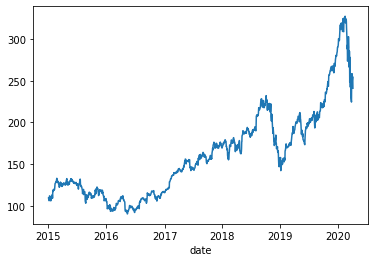

In [125]:
# Find local peaks
df['min'] = df.close[(df.close.shift(1) > df.close) & (df.close.shift(-1) > df.close)]
df['max'] = df.close[(df.close.shift(1) < df.close) & (df.close.shift(-1) < df.close)]

#print(df)

# Plot results
#plt.scatter(df.index, df['min'], c='r')
#plt.scatter(df.index, df['max'], c='g')
df.close.plot()

In [126]:
#set some default variables
bank = 100000 #set initial investor capital
portfolio = {ticker: 0} #initialize empty portfolio
num_contracts = 1 #trade one contract at a time

In [176]:
#get categorical columns for closing price, trading volume, and sentiment

def price_categorize(col): #start with price. don't replace price values with categories because they're needed to calculate reward/profit
    
    new_col = np.empty(len(col), dtype="<U4")
    for i in range(len(col)):
        if i == 0 or col[i] == col[i-1]:
            new_col[i] = 'same'
            
        elif col[i] < col[i-1]:
            new_col[i] = 'down'
            
        else:
            new_col[i] = 'up'
            
    return new_col

price_config = 'close' #use close to determine price
price_movements = price_categorize(df[price_config])


#get categorical volume column
quantiles = (df.volume.quantile(1/3), df.volume.quantile(2/3))

tri = [0] * len(df) #3 quantile separator

for i in range(len(df['volume'])): #replace volume counts with categories
    if df['volume'][i] <= quantiles[0]:
        tri[i] = 'low'
    elif df['volume'][i] <= quantiles[1]:
        tri[i] = 'med'
    else:
        tri[i] = 'high'

df = df.assign(volume=tri)



#get categorical sentiment column

quantiles = (df.sentiment.quantile(1/3), df.sentiment.quantile(2/3))
tri2 = [0] * len(df)

for i in range(len(df['sentiment'])): #replace volume counts with categories
    if df['sentiment'][i] <= quantiles[0]:
        tri2[i] = 'neg' #negative
    elif df['sentiment'][i] <= quantiles[1]:
        tri2[i] = 'neut' #neutral
    else:
        tri2[i] = 'pos' #positive

df = df.assign(sentiment=tri2)

In [128]:
def buy(stock_df, portfolio, date, capital, num_contracts=1): 
    
    transaction_cost = stock_df.at[date, price_config] * (num_contracts * 100)
    
    if capital < transaction_cost:
        return False #can't buy if you lack the funds
    
    current_holdings = portfolio[ticker]
        
    return {ticker: current_holdings+num_contracts}, -transaction_cost #approve transaction, return updated one-stock portfolio and profit/loss (-1 * transaction_cost)
    
    
def sell(stock_df, portfolio, date, num_contracts=1):  #capital is irrelevant for selling (you can sell with any amount of capital, as long as you have enough shares)
    
    if not portfolio[ticker] or num_contracts > portfolio[ticker]:
        return False #can't sell shares you don't own
    
    gain = stock_df.at[date, price_config] * (num_contracts * 100) 
    
    current_holdings = portfolio[ticker]
    
    return {ticker: current_holdings-num_contracts}, gain #approve transaction, return updated one-stock portfolio and gain

In [129]:
def max_profit(df, ticker, capital, num_contracts=1):
    portfolio = {ticker: 0}
    extrema = df.dropna(thresh=len(df.columns)-1) #drop row if min and max both nan #how='all', subset=['min', 'max'])

    for trading_day in df.index.values:
        
        b = buy(df, portfolio, trading_day, capital)
        s = sell(df, portfolio, trading_day)
        
        if b and not pd.isnull(df.at[trading_day, 'min']): #not nan on min col: it's a local min
            portfolio = b[0]
            capital += b[1]
                
        elif s and not pd.isnull(df.at[trading_day, 'max']):
            portfolio = s[0]
            capital += s[1]
            
    return capital, portfolio

mx_prof = max_profit(df, ticker, bank)
print('max final portfolio value:', mx_prof[0])

max final portfolio value: 221750.99639892578


In [178]:
import itertools

trend_features = ('up', 'down', 'same')
vol_features = ('low', 'med', 'high')
sent_features = ('neg', 'neut', 'pos')

state_features = ( trend_features, vol_features, sent_features ) #will expand over time
states = list(itertools.product(*state_features))

print(states) #all combinations of one element from each state feature tuple
#list(itertools.product(*[ ('up', 'down', 'same'), ('low', 'med', 'high'), ('good', 'ok', 'bad'), ('nay', 'kay', 'yay') ]))

[('up', 'low', 'neg'), ('up', 'low', 'neut'), ('up', 'low', 'pos'), ('up', 'med', 'neg'), ('up', 'med', 'neut'), ('up', 'med', 'pos'), ('up', 'high', 'neg'), ('up', 'high', 'neut'), ('up', 'high', 'pos'), ('down', 'low', 'neg'), ('down', 'low', 'neut'), ('down', 'low', 'pos'), ('down', 'med', 'neg'), ('down', 'med', 'neut'), ('down', 'med', 'pos'), ('down', 'high', 'neg'), ('down', 'high', 'neut'), ('down', 'high', 'pos'), ('same', 'low', 'neg'), ('same', 'low', 'neut'), ('same', 'low', 'pos'), ('same', 'med', 'neg'), ('same', 'med', 'neut'), ('same', 'med', 'pos'), ('same', 'high', 'neg'), ('same', 'high', 'neut'), ('same', 'high', 'pos')]


In [179]:
import random
def arg_max(row): #pandas idxmax returns the first index of the max value in case of a tie; we want a random index instead
    maxes = row[row == row.max()]
    return random.choice(maxes.index)
    

actions = ('buy', 'sell', 'hold')

num_portfolios = 1

training_set = df[df.index < datetime.date(2019, 1, 1)]
test_set = df[df.index >= datetime.date(2019, 1, 1)]

def q_learn(df, ticker, bank, risk_tolerance, alpha, decay_rate, gamma):
    
    #initialize
    q = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    portfolio = {ticker: 0}
    i = 0
    
    initial_trend = price_movements[i]
    initial_vol = df.at[df.index[i], 'volume']
    initial_sent = df.at[df.index[i], 'sentiment']
    initial_state = (initial_trend, initial_vol, initial_sent)

    for pf in range(num_portfolios): #iterate through the number of portfolios you're processing
        
        s = initial_state
        
        while bank > 0 and i < len(df)-1: #stop on the day before the last (we use the next day's profit/loss to get the reward):
            
            e = decay_rate ** i #decayed-epsilon-greedy method, inspired by https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp%2C_T._1.pdf?sequence=1
            
            current_date = df.index[i]
            current_price = df.at[current_date, price_config]
            next_date = df.index[i+1]
            next_price = df.at[next_date, price_config]
            
            #list out what actions you can take (can you buy and/or sell?)
            possible_actions = ['hold']
            
            long = buy(df, portfolio, current_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, current_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
            
            
            #factor in epsilon
            if random.random() < e:
                a = random.choice(possible_actions)
            
            else:
                a = arg_max(q.loc[s][possible_actions])
                
                
            if a == 'buy':
                portfolio[ticker] += num_contracts #update number of shares held
                bank += long[1] #update account
                reward = (next_price - current_price) * num_contracts * 100 #reward should be profit from next day. if you buy and the price went up, you get a positive reward
            
            if a == 'hold':
                reward = -risk_tolerance #user-specified penalty on holding
            
            if a == 'sell':    
                portfolio[ticker] -= num_contracts #update number of shares held
                bank += short[1] #update account
                reward = (current_price - next_price) * num_contracts * 100 #reward should be profit from next day. if you sell and the price goes down, you get a positive reward
            
            trend = price_movements[i+1]
            vol = df.at[next_date, 'volume']
            sent = df.at[next_date, 'sentiment']
            
            #list out what actions you can take on the next trading day
            
            possible_actions = ['hold']
            
            long = buy(df, portfolio, next_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, next_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
            
            s_next = (trend, vol, sent)
            q_next = q.at[s_next, arg_max(q.loc[s_next][possible_actions])]
            
            q_inc = alpha * ( reward + gamma * q_next - q.at[s, a])
            q.at[s, a] += q_inc
            
            s = s_next
            i += 1
    
    bank += next_price * portfolio[ticker] * 100
    #print( {'risk level': risk_tolerance, 'alpha': alpha, 'balance': bank } )
    
    return bank, portfolio, q
                    

In [132]:
#function to decay weight, y: 5 ** (-i/150)
#train = q_learn(training_set, ticker, bank, 25)

In [133]:
#print (train[0], train[1], '\n\n', train[2]) #learned q values

In [180]:
test_trends = price_movements[len(training_set):]

def q_test(test_data, ticker, bank, q):
    
    #initialize
    portfolio = {ticker: 0}
    i = 0
    
    initial_trend = test_trends[i]
    initial_vol = test_set.at[test_set.index[i], 'volume']
    initial_sent = test_set.at[test_set.index[i], 'sentiment']
    initial_state = (initial_trend, initial_vol, initial_sent)
    
    action_list = []
    
    for pf in range(num_portfolios): #iterate through the number of portfolios you're processing
        
        s = initial_state
        
        #for testing

        while bank > 0 and i < len(test_data)-1: #stop on the day before the last (we use the next day's profit/loss to get the reward):
            
            current_date = test_data.index[i]
            current_price = test_data.at[current_date, price_config]
            next_date = test_data.index[i+1]
            next_price = test_data.at[next_date, price_config]
            
            #list out what actions you can take (can you buy and/or sell?)
            possible_actions = ['hold']
            
            long = buy(df, portfolio, current_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, current_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
                 
            a = arg_max(q.loc[s][possible_actions])
                
            if a == 'buy':
                portfolio[ticker] += num_contracts #update number of shares held
                bank += long[1] #update account
                
            if a == 'sell':    
                portfolio[ticker] -= num_contracts #wqa_P;0dupdate number of shares held
                bank += short[1] #update account
            
            trend = price_movements[i+1]
            vol = df.at[next_date, 'volume']
            sent = df.at[next_date, 'sentiment']
            s = (trend, vol, sent) #get next state
            
            i += 1
    
    bank += next_price * portfolio[ticker] * 100
    
    return bank, portfolio
                    

In [135]:
#test_run = q_test(test_set, ticker, bank, train[2])
#print(test_run)

In [136]:
'''profits = []

for i in range(100):
    train_vals = q_learn(training_set, ticker, bank, i)
    test_run = q_test(test_set, ticker, bank, train_vals[2])
    ret_dict = {'profit': test_run[0] - bank, 'shares_held': test_run[1][ticker] * 100}
    profits.append( {i: ret_dict} )'''

"profits = []\n\nfor i in range(100):\n    train_vals = q_learn(training_set, ticker, bank, i)\n    test_run = q_test(test_set, ticker, bank, train_vals[2])\n    ret_dict = {'profit': test_run[0] - bank, 'shares_held': test_run[1][ticker] * 100}\n    profits.append( {i: ret_dict} )"

In [137]:
#print(profits)

In [181]:
#cross-validation

#helper for s_fold: creates the folds
def s_partition(s, data): 
    
    fold_size = math.ceil( len(data) / s ) #take the ceiling so no elements are missed in the case of an uneven split
    
    folded_data = [] #store folds in a list
    
    i = 0
    while i < len(data):
        
        #append the folds, incrementing by the size of each fold
        folded_data.append(data[i:i+fold_size]) 
        
        i += fold_size
        
    return folded_data

#q_learn(df, ticker, bank, risk_tolerance, alpha=0.01, e=1, y=1):
#return bank, portfolio, q

def s_fold(folds, data, model, model_args):
    
    folded_data = s_partition(folds, data)
    q = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    
    for data_fold_index in range(folds):
        
        #exclude current fold, use other folds as training data
        training_data = folded_data[:data_fold_index] + folded_data[data_fold_index+1:] #3d array: each element is a 2d data fold
        training_data = pd.concat(training_data) #combine the 3d array into one single 2d data array to use as the feature input
        
        learner = model(training_data, **model_args) #fit model to other partitions
        
        q += learner[2]
        
    q /= folds #get "average" q values    
    return q

In [139]:
#k = 10
#risk_tolerance = 10

#cross_q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 'risk_tolerance': risk_tolerance})

In [140]:
#cross_q

In [141]:
#q_test(test_data, ticker, bank, q)

#test_run = q_test(test_set, ticker, bank, cross_q)
#print(test_run)

In [182]:
#hyperparameter tuning

learning_rates = (0.001, 0.01, 0.1)
#risk_levels = (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
risk_levels = (0, 25, 50, 75, 100)
decay_rates = (0.9, 0.99, 0.999)
gammas = (0.0, 0.25, 0.5, 0.75, 1)

#total runs = 3 * 5 * 3 * 5 = 225

k = 5
highest_bank = -1

#initialize empty dictionaries of profit values for each hyperparameter. these will be averaged to find the optimal parameters
learning_profits, risk_profits, decay_profits, gamma_profits = dict.fromkeys(learning_rates, 0), dict.fromkeys(risk_levels, 0), dict.fromkeys(decay_rates, 0), dict.fromkeys(gammas, 0)

runs = []

for learning_rate in learning_rates:
    for gamma in gammas:
        for epsilon in decay_rates:
            for risk_level in risk_levels: #test risk levels in increments of 10
                
                cross_q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 
                        'risk_tolerance': risk_level, 'alpha': learning_rate, 'decay_rate': epsilon, 'gamma': gamma})
                bal = q_test(test_set, ticker, bank, cross_q)[0]

                if bal > highest_bank:
                    best_params = {'balance': bal, 'risk level': risk_level, 'alpha': learning_rate,
                                  'epsilon': epsilon, 'gamma': gamma}
                    highest_bank = bal
                    
                risk_profits[risk_level] += bal
                decay_profits[epsilon] += bal
                gamma_profits[gamma] += bal
                learning_profits[learning_rate] += bal
                    
                run = {'balance': bal, 'risk level': risk_level, 'alpha': learning_rate,
                                  'epsilon': epsilon, 'gamma': gamma}
                
                print(run)
                
                runs.append(run)
                
            
        

            
print('optimal parameters:', best_params)            
print(cross_q)

#next step: tune with epsilon and gamma

{'balance': 154225.99029541019, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 151502.0034790039, 'risk level': 25, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 168905.0018310547, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 157326.99584960943, 'risk level': 75, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 150167.9931640626, 'risk level': 100, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'balance': 142029.0008544922, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 168720.0027465821, 'risk level': 25, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 157946.00219726562, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 155742.9946899414, 'risk level': 75, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 155956.99005126956, 'risk level': 100, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'balance': 162560.9985351563, 'risk leve

{'balance': 151471.9940185547, 'risk level': 0, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'balance': 154739.00146484384, 'risk level': 25, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'balance': 152730.99365234384, 'risk level': 50, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'balance': 149486.0000610352, 'risk level': 75, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'balance': 164805.99212646487, 'risk level': 100, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'balance': 143316.9998168945, 'risk level': 0, 'alpha': 0.01, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 141671.00830078128, 'risk level': 25, 'alpha': 0.01, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 155478.99475097662, 'risk level': 50, 'alpha': 0.01, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 153383.99047851568, 'risk level': 75, 'alpha': 0.01, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 158093.994140625, 'risk level': 100, 'alpha': 0.01, 'epsilon': 0.9, 'gamma': 0.25}
{'balance': 128241.99676513672, 'risk le

{'balance': 149338.00048828125, 'risk level': 25, 'alpha': 0.1, 'epsilon': 0.99, 'gamma': 0.25}
{'balance': 152871.99707031253, 'risk level': 50, 'alpha': 0.1, 'epsilon': 0.99, 'gamma': 0.25}
{'balance': 152309.99298095703, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.99, 'gamma': 0.25}
{'balance': 151744.9935913086, 'risk level': 100, 'alpha': 0.1, 'epsilon': 0.99, 'gamma': 0.25}
{'balance': 149164.99786376956, 'risk level': 0, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.25}
{'balance': 160174.00054931646, 'risk level': 25, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.25}
{'balance': 158580.99975585943, 'risk level': 50, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.25}
{'balance': 149612.99896240237, 'risk level': 75, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.25}
{'balance': 144067.99774169928, 'risk level': 100, 'alpha': 0.1, 'epsilon': 0.999, 'gamma': 0.25}
{'balance': 184583.99810791016, 'risk level': 0, 'alpha': 0.1, 'epsilon': 0.9, 'gamma': 0.5}
{'balance': 153535.9985351562, 'risk l

In [183]:
'''def avgRun(param_dict, total_runs):
    for param in param_dict.keys():
        param_dict[param] /= (total_runs / len(param_dict.keys() ) ) #divide total of all balances by number of runs associated with each parameter to get the average
    return param_dict

total_runs = len(learning_profits.keys()) * len(risk_profits.keys()) * len(decay_profits.keys()) * len(gamma_profits.keys())
learning_profits, risk_profits, decay_profits, gamma_profits = avgRun(learning_profits, total_runs), avgRun(risk_profits, total_runs), avgRun(decay_profits, total_runs), avgRun(gamma_profits, total_runs)

print(learning_profits, risk_profits, decay_profits, gamma_profits)'''

{0.001: 156692.5698445638, 0.01: 156504.8503417969, 0.1: 153168.82594807944} {0: 158461.81918674044, 25: 156790.08724636503, 50: 155209.31006537544, 75: 153908.5302734375, 100: 152907.33011881512} {0.9: 157533.11804199222, 0.99: 155891.67781575522, 0.999: 152941.45027669275} {0.0: 157555.99700927734, 0.25: 153571.8423800998, 0.5: 155585.1773071289, 0.75: 154212.79673258463, 1: 156351.26346164278}


So the best learning rate is 0.1, the best risk level is 0, the best value at which to begin the decay is 0.9, and the best discount factor is 0.5 (equally balancing long and short term gain).

In [187]:
k = 10
#best_params = {'balance': bank, 'risk level': 0, 'alpha': 0.1,
#                                  'epsilon': 0.9, 'gamma': 0.5}

q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 
                        'risk_tolerance': best_params['risk level'], 
                        'alpha': best_params['alpha'], 'decay_rate': best_params['epsilon'], 'gamma': best_params['gamma']})

#test_set = df.query('index >= datetime.date(2019, 1, 1) & index < datetime.date(2020, 1, 1)')
test_run = q_test(test_set, ticker, bank, q)
output = {'balance': test_run[0], 'risk level': best_params['risk level'], 'alpha': best_params['alpha'],
                                  'epsilon': best_params['epsilon'], 'gamma': best_params['gamma']}
print(output)

{'balance': 176719.9966430664, 'risk level': 0, 'alpha': 0.1, 'epsilon': 0.9, 'gamma': 0.5}


In [188]:
test_set = df.query('index >= datetime.date(2019, 1, 1) & index < datetime.date(2020, 1, 1)')
test_run = q_test(test_set, ticker, bank, q)
output = {'balance': test_run[0], 'risk level': best_params['risk level'], 'alpha': best_params['alpha'],
                                  'epsilon': best_params['epsilon'], 'gamma': best_params['gamma']}
print(output)

{'balance': 176719.9966430664, 'risk level': 0, 'alpha': 0.1, 'epsilon': 0.9, 'gamma': 0.5}
